# AlexNet
AlexNet famously won the 2012 ImageNet LSVRC-2012 competition by a large margin (15.3% VS 26.2% (second place) error rates).

### The highlights of the paper
- Use Relu instead of Tanh to add non-linearity. It accelerates the speed by 6 times at the same accuracy.
- Use dropout instead of regularisation to deal with overfitting. However the training time is doubled with the dropout rate of 0.5.
- Overlap pooling to reduce the size of network. It reduces the top-1 and top-5 error rates by 0.4% and 0.3%, repectively.

### The architecture
It contains 5 convolutional layers and 3 fully connected layers. Relu is applied after very convolutional and fully connected layer. Dropout is applied before the first and the second fully connected year. The image size in the following architecutre chart should be 227 * 227 instead of 224 * 224, as it is pointed out by Andrei Karpathy in his famous CS231n Course.

![orignal_architech.png](./images/orignal_architech.png)

# AlexNet implementation on Cifar 10

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

is_gpu_available = torch.cuda.is_available()

if is_gpu_available:
    print("CUDA is available!  Training on GPU ...")
else:
    print("CUDA is not available!  Training on CPU ...")

CUDA is available!  Training on GPU ...


## Data Loading and Preprocessing

### CIFAR10 small image classification
Dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.

#### Returns 2 tuples:
- **train_data**: uint8 array of RGB image data with shape (num_samples, 32, 32, 3).
- **test_data**: uint8 array of category labels (integers in range 0-9) with shape (num_samples,).

In [3]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CIFAR10('data', train=True, transform=transform, download=True)
test_data = CIFAR10('data', train=True, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
num_classes = 10
print("Number of training examples =", len(train_data))
print("Number of testing examples =", len(test_data))
print("Image data shape =", train_data[0][0].shape)
print("Number of classes =", num_classes)

Number of training examples = 50000
Number of testing examples = 50000
Image data shape = torch.Size([3, 32, 32])
Number of classes = 10


In [9]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=20, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=20, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=20)

## Visualize a Batch of Training Data

In [13]:
def imshow(image):
    img = image.numpy()
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

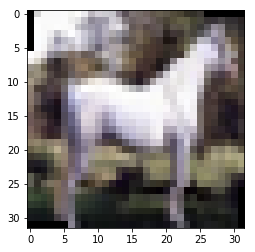

In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(images[0])

## Model Implementation

In [16]:
from torch.nn import Conv2d, MaxPool2d, Linear, Module, Softmax, Dropout, BatchNorm1d, BatchNorm2d
import torch.nn.functional as F

### Model Architecture
The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

- **Convolution with 64 different filters in size of (3x3)**
    - ReLU activation function
- **Max Pooling by 2**
    - Batch Normalization
- **Convolution with 128 different filters in size of (3x3)**
    - ReLU activation function
- **Max Pooling by 2**
    - Batch Normalization
- **Convolution with 256 different filters in size of (3x3)**
    - ReLU activation function
- **Max Pooling by 2**
    - Batch Normalization
- **Convolution with 512 different filters in size of (3x3)**
    - ReLU activation function
- **Max Pooling by 2**
    - Batch Normalization
- **Flattening the 3-D output of the last convolving operations.**
- **Fully Connected Layer with 128 units**
    - ReLU activation function
    - Dropout
    - Batch Normalization
- **Fully Connected Layer with 256 units**
    - ReLU activation function
    - Dropout
    - Batch Normalization
- **Fully Connected Layer with 512 units**
    - ReLU activation function
    - Dropout
    - Batch Normalization
- **Fully Connected Layer with 1024 units**
    - ReLU activation function
    - Dropout
    - Batch Normalization
- **Fully Connected Layer with 10 units (number of image classes)**
    - Softmax activation function

In [22]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = Conv2d(3, 64, 3, padding=1)
        self.conv1_bn = BatchNorm2d(64)
        
        self.conv2 = Conv2d(64, 128, 3, padding=1)
        self.conv2_bn = BatchNorm2d(128)
        
        self.conv3 = Conv2d(128, 256, 3, padding=1)
        self.conv3_bn = BatchNorm2d(256)
        
        self.conv4 = Conv2d(256, 512, 3, padding=1)
        self.conv4_bn = BatchNorm2d(512)
        
        self.fc1 = Linear(2*2*512, 128)
        self.fc1_bn = BatchNorm1d(128)
        
        self.fc2 = Linear(128, 256)
        self.fc2_bn = BatchNorm1d(256)
        
        self.fc3 = Linear(256, 512)
        self.fc3_bn = BatchNorm1d(512)
        
        self.fc4 = Linear(512, 1024)
        self.fc4_bn = BatchNorm1d(1024)
        
        self.fc5 = Linear(1024, 10)
        
        self.dropout = Dropout(0.25)
        
        self.pool = MaxPool2d(2, stride=2)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv1_bn(self.pool(x))
        
        x = F.relu(self.conv2(x))
        x = self.conv2_bn(self.pool(x))
        
        x = F.relu(self.conv3(x))
        x = self.conv3_bn(self.pool(x))
        
        x = F.relu(self.conv4(x))
        x = self.conv4_bn(self.pool(x))
        
        x = x.view(-1, 2*2*512)
        
        x = F.relu(self.fc1(x))
        x = self.fc1_bn(self.dropout(x))
        
        x = F.relu(self.fc2(x))
        x = self.fc2_bn(self.dropout(x))
        
        x = F.relu(self.fc3(x))
        x = self.fc3_bn(self.dropout(x))
        
        x = F.relu(self.fc4(x))
        x = self.fc4_bn(self.dropout(x))
        
        x = self.fc5(x)
        
        return x

In [23]:
# create a complete CNN
model = Net()
print(model)

if is_gpu_available:
    model.cuda()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc2_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [24]:
from torch.nn import CrossEntropyLoss
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training

In [25]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
total_train_loss = []
total_valid_loss = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    total_train_loss.append(train_loss)
    total_valid_loss.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.327045 	Validation Loss: 0.250661
Validation loss decreased (inf --> 0.250661).  Saving model ...
Epoch: 2 	Training Loss: 1.054061 	Validation Loss: 0.219735
Validation loss decreased (0.250661 --> 0.219735).  Saving model ...
Epoch: 3 	Training Loss: 0.929456 	Validation Loss: 0.189043
Validation loss decreased (0.219735 --> 0.189043).  Saving model ...
Epoch: 4 	Training Loss: 0.853516 	Validation Loss: 0.175183
Validation loss decreased (0.189043 --> 0.175183).  Saving model ...
Epoch: 5 	Training Loss: 0.776467 	Validation Loss: 0.161949
Validation loss decreased (0.175183 --> 0.161949).  Saving model ...
Epoch: 6 	Training Loss: 0.720792 	Validation Loss: 0.156949
Validation loss decreased (0.161949 --> 0.156949).  Saving model ...
Epoch: 7 	Training Loss: 0.682167 	Validation Loss: 0.147626
Validation loss decreased (0.156949 --> 0.147626).  Saving model ...
Epoch: 8 	Training Loss: 0.644535 	Validation Loss: 0.140517
Validation loss decreased (0.14762

## Testing

In [26]:
model.load_state_dict(torch.load('model_cifar.pt'))
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(20):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.303076

Test Accuracy of airplane: 91% (4580/5000)
Test Accuracy of automobile: 96% (4827/5000)
Test Accuracy of  bird: 87% (4390/5000)
Test Accuracy of   cat: 78% (3916/5000)
Test Accuracy of  deer: 91% (4576/5000)
Test Accuracy of   dog: 85% (4299/5000)
Test Accuracy of  frog: 92% (4648/5000)
Test Accuracy of horse: 93% (4658/5000)
Test Accuracy of  ship: 95% (4791/5000)
Test Accuracy of truck: 93% (4678/5000)

Test Accuracy (Overall): 90% (45363/50000)


In [11]:
model.save('model.h5')
history = model.history

## Results
 
### Training from scratch

Training AlexNet, using stochastic gradient descent with a fixed learning rate of 0.01, for 50 epochs, we acheive a test accuracy of ~76.75%.

In accuracy and loss plot shown below, notice the large gap between the training and testing curves. This suggests that our model is overfitting.

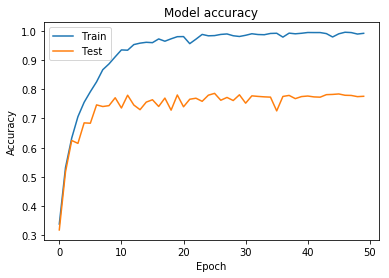

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

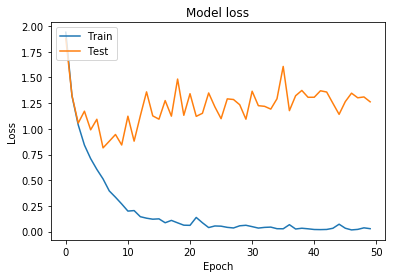

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Todo
- Expriment to stop model overfiting